# Online Non-Negative Matrix Factorization using Hebbian/Anti-Hebbian network

A third-party reimplementation of the paper: "A Hebbian/Anti-Hebbian Network Derived from Online Non-Negative Matrix Factorization Can Cluster and Discover Sparse Features"
https://arxiv.org/abs/1503.00680

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

## Dataset
First prepare the dataset for clustering.

In [2]:
np.random.seed(10)
x0 = np.random.normal(0.0, 1.0, [100, 2]) * np.sqrt(0.04) + [-0.0985, -0.3379] # (100, 2)
x1 = np.random.normal(0.0, 1.0, [100, 2]) * np.sqrt(0.04) + [-0.6325,  0.9322] # (100, 2)
x2 = np.random.normal(0.0, 1.0, [100, 2]) * np.sqrt(0.04) + [1.1078,   1.0856] # (100, 2)

y0 = np.array([0] * 100, dtype=np.int32)
y1 = np.array([1] * 100, dtype=np.int32)
y2 = np.array([2] * 100, dtype=np.int32)

X = np.vstack([x0, x1, x2]) # 300, 2
c = np.hstack([y0, y1, y2]) # 300

indices = np.arange(len(X))
np.random.shuffle(indices)

X = X[indices]
c = c[indices]

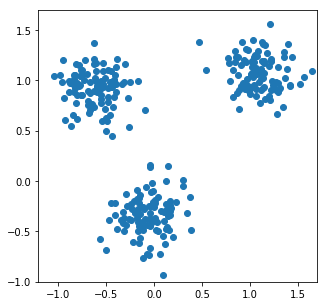

In [3]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1])
plt.xlim(-1.2, 1.7)
plt.ylim(-1.0, 1.7)
plt.show()

In [4]:
x_dim = X.shape[1] # 2
T = X.shape[0] # 300
y_dim = 3

## Training

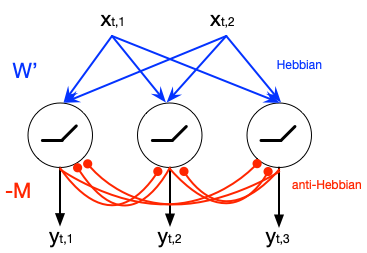

Activation of the output node is,

$$
y_{T,i} = ReLU(W_{T,i} x_T - M_{T,i} y_T)
$$

Weight update rule is

$$
\hat{Y}_{T,i} = \hat{Y}_{T-1,i} + y^2_{T-1,i} 
$$

$$
W_{T,i,j} = W_{T-1,i,j} + \frac{y_{T-1,i} \left( x_{T-1,j} - W_{T-1,i,j} y_{T-1,i} \right)} {\hat{Y}_{T,i}} 
$$

$$
M_{T,i,j\ne i} = M_{T-1,i,j} + \frac{y_{T-1,i} \left( y_{T-1,j} - M_{T-1,i,j} y_{T-1,i}  \right) } { \hat{Y}_{T,i} }
$$

In [5]:
def update_weight(W, M, x_t, y_t, y_hat):
    """ Update weight matrix of W and M.
    Equation (8) in the original paper.
    """
    y_dim = y_t.shape[0]
    y_hat += (y_t * y_t)
    
    # (3,1) x (1,2) = (3,2)
    dW = y_t[:,np.newaxis].dot( x_t[np.newaxis,:] - (W.T.dot(y_t[:,np.newaxis])).T)
    #dW = dW / y_hat[:,np.newaxis]
    # (3, 2)
    
    for i in range(y_dim):
        if y_hat[i] > 0:
            W[i] += (dW[i] / y_hat[i])
    
    # (3,1) x (1,3) = (3,3)
    dM = y_t[:,np.newaxis].dot( y_t[np.newaxis,:] - (M.T.dot(y_t[:,np.newaxis])).T)
    #dM = dM / y_hat[:,np.newaxis]
    
    # Set diagonal elements to zero
    for i in range(M.shape[0]):
        dM[i,i] = 0.0
    
    for i in range(y_dim):
        if y_hat[i] > 0:
            M[i] += (dM[i] / y_hat[i])

If the i-th degree of freedom has not been utilized, then adjust the output.

$$
y_{Ti} = \left\{
\begin{array}{l}
0, \quad\left(\left\|x_{T}\right\|^{2}_2-\sum_{k=1, k \neq i}^{m} y_{Tk}^{2}\right)^{2} \leq \lambda \\
\left(\left\|x_{T}\right\|^{2}_2-\sum_{k=1, k \neq i}^{m} y_{Tk}^{2}\right)^{1 / 2}, \left(\left\|x_{T}\right\|^{2}_2-\sum_{k=1, k \neq i}^{m} y_{Tk}^{2}\right)^{2}>\lambda
\end{array}
\right.
$$

In [6]:
def adjust_y_i(y_t, x_t, y_index, lambd=0.6):
    """ If the node in y_t is not active previously, adjust it.
    Equation (5) in the original paper.
    """
    # y_t = (3,)
    # x_t = (2,)
    
    y_dim = y_t.shape[0]
    
    # Calculate squree L2 norm of x_t
    x_norm_sq = x_t.dot(x_t)    
    y_t_sqs = y_t * y_t # (3,)
    
    y_t_adj = np.empty_like(y_t)
    
    d_i = x_norm_sq - (np.sum(y_t_sqs) - y_t_sqs[y_index])
    d_i_sq = d_i * d_i
    if d_i_sq <= lambd:
        return 0.0
    else:
        if d_i < 0.0:
            print("d_i was negative: {}".format(d_i))
            d_i = 0.0
    return np.sqrt(d_i)

In [7]:
W = np.zeros([y_dim, x_dim]) # (3, 2)
M = np.zeros([y_dim, y_dim]) # (3, 3)

# Active set {i}
active_i_s = []
active_counts = np.zeros([y_dim], dtype=np.int32)

# Iteration count for convergence
iteration = 100

y_t_sum = np.zeros([y_dim])
y_hat = np.zeros([y_dim]) # 3

clusters = []

for t in range(T):
    # Get one input sample x_t
    x_t = X[t] # (2,)
    
    # Zero initialze y_t
    y_t = np.zeros(y_dim)
    for i in active_i_s:
        # If 'i' is in the active set {i}
        for it in range(iteration):
            # W[i] = (2,)
            # M[i] = (3,)
            a = W[i].dot(x_t) - M[i].dot(y_t)
            # a is scaler
            y_t_i = max(0, a)
        y_t[i] = y_t_i
    
    for i in range(y_dim):
        if active_counts[i] == 0:
            y_t[i] = adjust_y_i(y_t, x_t, i)
                
    for i in range(y_dim):
        if y_t[i] != 0.0:
            active_counts[i] += 1
            
    for i in range(y_dim):
        if (i not in active_i_s) and active_counts[i] > 0:
            active_i_s.append(i)

    update_weight(W, M, x_t, y_t, y_hat)
    
    cluster = np.argmax(y_t)
    clusters.append(cluster)

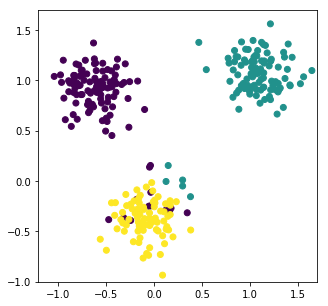

In [8]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.xlim(-1.2, 1.7)
plt.ylim(-1.0, 1.7)
plt.show()

In [9]:
print(active_i_s)

[0, 1, 2]
